In [1]:
import os
import sys

import json
import numpy as np
import people

import matplotlib.pyplot as plt

import keras.backend as K

from people.datasets import Human36M

from people.evaluation import average_world_poses
from people.evaluation import eval_human36m_activities

from people.utils import *


from people import datasetpath
from people.datasets.human36m import ZBOUND
from people.datasets.human36m import BBOX_REF

Initializing people v.0.1.0
CUDA_VISIBLE_DEVICES not defined
Using TensorFlow backend.
/home/diogo/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/diogo/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/diogo/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/d

In [2]:
datasetpath('Human3.6M')

'/storage/diogo/Datasets/Human3.6M'

In [3]:
h36m = Human36M(datasetpath('Human3.6M'), DataConfig(), [(32, 32)],
        image_div=8, poselayout=est34j3d, preprocess_mode='caffe')

poselayout = est34j3d
num_joints = poselayout.num_joints
anchor_id = 0

saveddir = 'output/pred_h36m_022_val'

p0_h36m = np.load(os.path.join(saveddir, 'p_h36m_hf0.npy'))
p1_h36m = np.load(os.path.join(saveddir, 'p_h36m_hf1.npy'))
afmat0_h36m = np.load(os.path.join(saveddir, 'afmat_h36m_hf0.npy'))
afmat1_h36m = np.load(os.path.join(saveddir, 'afmat_h36m_hf1.npy'))
pred0_z = np.load(os.path.join(saveddir, 'pred_absz_hf0.npy'))
pred1_z = np.load(os.path.join(saveddir, 'pred_absz_hf1.npy'))
pred0_p = np.load(os.path.join(saveddir, 'pred_pose_hf0.npy'))
pred1_p = np.load(os.path.join(saveddir, 'pred_pose_hf1.npy'))

pw_h36m = np.load(os.path.join(saveddir, 'pw_h36m_hf0.npy'))
rootz_h36m = np.load(os.path.join(saveddir, 'rootz_h36m_hf0.npy'))
scam_h36m = np.load(os.path.join(saveddir, 'scam_h36m_hf0.npy'))
action_h36m = np.load(os.path.join(saveddir, 'action_h36m_hf0.npy'))

with open(os.path.join(saveddir, 'meta_hf0.json'), 'r') as fid:
    meta_h36m = json.load(fid)

p1_h36m = p1_h36m[:, :, poselayout.map_hflip, :]
pred1_p = pred1_p[:, :, poselayout.map_hflip, :]

pw_h36m = pw_h36m[:, h36m23j3d.map_to_pa17j, :]

p0_h36m = p0_h36m[:, anchor_id, :, :3]
p0_h36m = p0_h36m[:, poselayout.map_to_pa17j, :]
p1_h36m = p1_h36m[:, anchor_id, :, :3]
p1_h36m = p1_h36m[:, poselayout.map_to_pa17j, :]

pred0_p = pred0_p[:, anchor_id, :, :3]
pred0_p = pred0_p[:, poselayout.map_to_pa17j, :]
pred1_p = pred1_p[:, anchor_id, :, :3]
pred1_p = pred1_p[:, poselayout.map_to_pa17j, :]

cameras = [camera_deserialize(c) for c in scam_h36m]
rootz = rootz_h36m[:, anchor_id:anchor_id+1]*(ZBOUND[1] - ZBOUND[0]) + ZBOUND[0]

pred0_z = pred0_z[:, anchor_id:anchor_id+1]*(ZBOUND[1] - ZBOUND[0]) + ZBOUND[0]
pred1_z = pred1_z[:, anchor_id:anchor_id+1]*(ZBOUND[1] - ZBOUND[0]) + ZBOUND[0]

In [4]:
# """Sanity check."""
pose_w = inverse_project_pose_to_camera_ref(p0_h36m, rootz, afmat0_h36m,
        cameras, resol_z=BBOX_REF, project_to_world=True)
err_w = np.mean(np.sqrt(np.sum(
                np.square(pw_h36m - pose_w), axis=-1)))
print ('Err_e on GT poses projected to world: ', err_w)

pose_c1 = inverse_project_pose_to_camera_ref(p0_h36m, rootz, afmat0_h36m,
        cameras, resol_z=BBOX_REF, project_to_world=False)

pose_c_gt = np.nan * np.ones(pw_h36m.shape)
for i in range(len(pose_c_gt)):
    pose_c_gt[i] = project_world2camera(cameras[i], pw_h36m[i])

err_c = abs_mpjpe(pose_c1, pose_c_gt)
print ('Err_e on GT poses projected to camera: ', err_c)

"""Predictions using GT camera parameters."""
pred0_w = inverse_project_pose_to_camera_ref(pred0_p.copy(), pred0_z.copy(),
            afmat0_h36m, cameras, resol_z=BBOX_REF, project_to_world=True)
pred1_w = inverse_project_pose_to_camera_ref(pred1_p.copy(), pred1_z.copy(),
            afmat1_h36m, cameras, resol_z=BBOX_REF, project_to_world=True)
pred_w = (pred0_w + pred1_w) / 2.

pred_c = np.nan * np.ones(pred_w.shape)
for i in range(len(pred_c)):
    pred_c[i] = project_world2camera(cameras[i], pred_w[i])

err_pred = abs_mpjpe(pred_c, pose_c_gt)
print ('ABS err on predicted poses using GT cameras: %.2f mm' % err_pred)

err_pred = rel_mpjpe(pred_c, pose_c_gt)
print ('REL err on predicted poses using GT cameras: %.2f mm' % err_pred)

puvd0 = pred0_p.copy()
puvd0[:, :, 0:2] = transform_pose_sequence(afmat0_h36m.copy(), puvd0[:, :, 0:2],
        inverse=True)
puvd0[:, :, 2] = BBOX_REF * (puvd0[:, :, 2] - 0.5) + pred0_z

puvd1 = pred1_p.copy()
puvd1[:, :, 0:2] = transform_pose_sequence(afmat1_h36m.copy(), puvd1[:, :, 0:2],
        inverse=True)
puvd1[:, :, 2] = BBOX_REF * (puvd1[:, :, 2] - 0.5) + pred1_z

puvd = (puvd0 + puvd1) / 2.

Err_e on GT poses projected to world:  0.12344697948330895
Err_e on GT poses projected to camera:  0.12344697948330399
ABS err on predicted poses using GT cameras: 89.47 mm
REL err on predicted poses using GT cameras: 49.29 mm


In [5]:
pc_gtcam = np.zeros(puvd.shape)
for i in range(len(puvd)):
    pc_gtcam[i] = camera_inv_proj(puvd[i],
            cameras[i].f[0,0], cameras[i].f[0,1],
            cameras[i].c[0,0], cameras[i].c[0,1])

print ('Results not considering the lens distortion coefficients:')

err_pred = abs_mpjpe(pc_gtcam, pose_c_gt)
print ('ABS err on predicted poses using est. cameras: %.2f mm' % err_pred)

err_pred = rel_mpjpe(pc_gtcam, pose_c_gt)
print ('REL err on predicted poses using est. cameras: %.2f mm' % err_pred)

Results not considering the lens distortion coefficients:
ABS err on predicted poses using est. cameras: 90.08 mm
REL err on predicted poses using est. cameras: 50.01 mm


In [6]:
def std_mpjpe(p1, p2):
    return np.std(np.sqrt(np.sum(np.square(p1 - p2), axis=-1)))

def dist_mpjpe(p1, p2):
    return np.sqrt(np.sum(np.square(p1 - p2), axis=-1))

def predict_camera_parameters(puvd1, puvd2, miniter=100, maxiter=600,
        alpha=0.8, f_init=500, c_init=500):

    assert puvd1.shape == puvd2.shape, \
        'Incompatible pose shapes {},{}'.format(puvd1.shape, puvd2.shape)
    
    # Initialize variables
    f1 = np.array([[f_init, f_init]])
    f2 = np.array([[f_init, f_init]])
    c1 = np.array([[c_init, c_init]])
    c2 = np.array([[c_init, c_init]])

    pc1 = predict_xy_mm(puvd1, f1, c1)
    pc2 = predict_xy_mm(puvd2, f2, c2)

    X1 = pc1
    X2 = np.concatenate([pc2, np.ones((len(pc2), 1))], axis=-1)
    P21_init = getP(X2, X1)

    pc1_init = project_poses(pc2, P21_init)
    t2 = -np.matmul(np.linalg.inv(P21_init[:,:3]), P21_init[:,3:4])
    loss = []
    prev_loss = 1e4
    min_loss = 1e4
    
    spl = range(len(puvd1))

    for i in range(maxiter):
        puvd1_b = puvd1[spl]
        puvd2_b = puvd2[spl]
        pc1_b = pc1[spl]
        pc2_b = pc2[spl]
        
        R21 = kabsch_alignment(pc2_b - t2.T, pc1_b)
        t2 = optimize_translation(pc2_b, pc1_b, R21)
        R12 = np.linalg.inv(R21)
        t1 = -np.matmul(R21, t2)

        P21 = np.concatenate([R21, t1], axis=-1)
        P12 = np.concatenate([R12, t2], axis=-1)

        if i % 4 == 0:
            f1 = optimize_focal(puvd1_b, pc2_b, P21, c1)
            f1[0,0] = alpha*f1[0,0] + (1-alpha)*f1[0,1]
            f1[0,1] = (1-alpha)*f1[0,0] + alpha*f1[0,1]

        elif i % 4 == 1:
            f2 = optimize_focal(puvd2_b, pc1_b, P12, c2)
            f2[0,0] = alpha*f2[0,0] + (1-alpha)*f2[0,1]
            f2[0,1] = (1-alpha)*f2[0,0] + alpha*f2[0,1]

        elif i % 4 == 2:
            c1 = optimize_center(puvd1_b, pc2_b, P21, f1)
            c1[0,0] = alpha*c1[0,0] + (1-alpha)*c1[0,1]
            c1[0,1] = (1-alpha)*c1[0,0] + alpha*c1[0,1]

        elif i % 4 == 3:
            c2 = optimize_center(puvd2_b, pc1_b, P12, f2)
            c2[0,0] = alpha*c2[0,0] + (1-alpha)*c2[0,1]
            c2[0,1] = (1-alpha)*c2[0,0] + alpha*c2[0,1]
        
        pc1 = predict_xy_mm(puvd1, f1, c1)
        pc2 = predict_xy_mm(puvd2, f2, c2)

        pc2c1 = project_poses(pc2, P21)
        err = abs_mpjpe(pc2c1, pc1)
        std = std_mpjpe(pc2c1, pc1)
        dist = dist_mpjpe(pc2c1, pc1)
        spl = dist < err + 2*std
        loss.append(err)

        if i > miniter and (loss[-1] > prev_loss or loss[-1] > min_loss + 1):
            break

        prev_loss = 0.5*prev_loss + 0.5*loss[-1]
        if loss[-1] < min_loss:
            min_loss = loss[-1]
            f1o = f1.copy()
            c1o = c1.copy()
            f2o = f2.copy()
            c2o = c2.copy()
            P21o = P21.copy()
            P12o = P12.copy()

    return f1o, c1o, f2o, c2o, P21o, P12o, np.array(loss)


In [7]:
cam_to_use = [1, 2, 3, 4]
pose_c_pred = np.zeros(pose_c_gt.shape)
alpha = 1 / len(cam_to_use)

e1_list = []
e2_list = []

i = 0
while i < len(pose_c_pred):
    a, s, e, c, f = meta_h36m[i]
    #print (a, s, e, c, f)

    idxs = {}
    for ic in range(4):
        idxs[ic+1] = get_idxs_sequence(meta_h36m, asec=(a, s, e, ic+1))

    try:
        pairlist = cam_to_use.copy()
        del pairlist[pairlist.index(c)]
    except:
        pass

    puvd1 = puvd[idxs[c]]
    cam1 = cameras[idxs[c][0]]
    if len(puvd1) == 0:
        print ('Warning! Sample %d %d %d %d empty!' % (a, s, e, c))
        continue
    num_samples, num_joints, dim = puvd1.shape
    pc_est = np.zeros((num_samples * num_joints, dim))

    for pc in pairlist:
        puvd2 = puvd[idxs[pc]]
        if len(puvd2) == 0:
            print ('Warning! Sample %d %d %d %d empty!' % (a, s, e, c))
            continue

        puvd1 = np.reshape(puvd1, (num_samples * num_joints, dim))
        puvd2 = np.reshape(puvd2, (num_samples * num_joints, dim))

        cam2 = cameras[idxs[pc][0]]

        t2cam1 = np.matmul(cam1.R, cam2.t-cam1.t)
        t1cam2 = np.matmul(cam2.R, cam1.t-cam2.t)

        #print (t2cam1.T)
        #print (t1cam2.T)

        f1, c1, f2, c2, P21, P12, loss = predict_camera_parameters(puvd1, puvd2)
        #print (f1, c1, f2, c2)
        #plt.plot(loss)

        #print ('t1', t1_est)
        #print ('t2', t2_est)
        e1 = abs_mpjpe(t2cam1, P21[:, -1:])
        e2 = abs_mpjpe(t1cam2, P12[:, -1:])
        #print (e1, e2)
        e1_list.append(e1)
        e2_list.append(e2)

        pc1_est = predict_xy_mm(puvd1, f1, c1)
        pc2_est = predict_xy_mm(puvd2, f2, c2)
        pc_est += alpha * pc1_est + (1 - alpha) * project_poses(pc2_est, P21)

    pc_est /= len(pairlist)
    #pc_gt = pose_c_gt[idxs[c]]
    #print (abs_mpjpe(pc_est, pc_gt), rel_mpjpe(pc_est, pc_gt))

    pc_est = np.reshape(pc_est, (num_samples, num_joints, dim))
    pose_c_pred[i:i+len(pc_est), :, :] = pc_est
    i += len(pc_est)

"""Removing empty sequences"""
for c in range(4):
    idxs = get_idxs_sequence(meta_h36m, asec=(2, 11, 2, c+1))
    pose_c_pred[idxs] = 0
    pose_c_gt[idxs] = 0

print (abs_mpjpe(pose_c_pred, pose_c_gt), rel_mpjpe(pose_c_pred, pose_c_gt))

Warning! Sample 2 11 2 2 empty!
Warning! Sample 2 11 2 3 empty!
Warning! Sample 2 11 2 4 empty!
114.92414622073764 43.528605876429474


In [90]:
print (np.array(e1_list).mean())
print (np.array(e2_list).mean())

179.5698924844859
188.07815776346024


In [8]:
from people.evaluation import eval_human36m_activities

pose_c_pred -= pose_c_pred[:, 0:1, :]
pose_c_gt -= pose_c_gt[:, 0:1, :]
eval_human36m_activities(pose_c_pred, pose_c_gt, action_h36m)

Directions: 55.9
Discussion: 38.2
Eating: 39.0
Greeting: 39.8
Phoning: 42.0
Posing: 39.5
Purchases: 41.2
Sitting: 67.5
SittingDown: 73.4
Smoking: 42.5
TakingPhoto: 45.1
Waiting: 40.3
Walking: 31.6
WalkingDog: 41.2
WalkingTogether: 35.8


In [9]:
prev_pred = np.load('pred_h36m_val_022d_079_multicam.npy')

print (abs_mpjpe(pose_c_pred, prev_pred), rel_mpjpe(pose_c_pred, prev_pred))
print (abs_mpjpe(pose_c_gt, prev_pred), rel_mpjpe(pose_c_gt, prev_pred))
print (abs_mpjpe(pose_c_gt, pose_c_pred), rel_mpjpe(pose_c_gt, pose_c_pred))

25.97586790345391 25.97586790345391
37.16420227842113 37.16420227842113
44.85988945268579 44.85988945268579


[[1226.53096709 1219.08934032]] [[506.17564355 506.03946699]] [[1189.75552262 1193.81291648]] [[475.25246835 475.64904758]]
47.95568630519882
58.93679194125264
54.012748533452196
499 55.24608504313956 55.24608504313956


/home/diogo/.local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


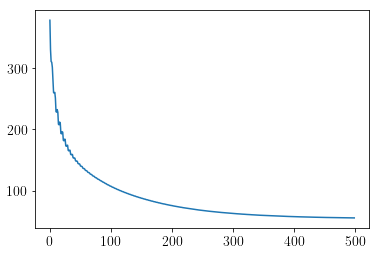

In [10]:
"""Load poses in uvd format for a set of cameras."""
idxs1 = get_idxs_sequence(meta_h36m, (2, 9, 1, 1))
idxs2 = get_idxs_sequence(meta_h36m, (2, 9, 1, 3))

#idxs1 = idxs1[0:1]
#idxs2 = idxs2[0:1]

puvd1 = puvd[idxs1]
puvd2 = puvd[idxs2]
pc1_gt = pose_c_gt[idxs1]
pc2_gt = pose_c_gt[idxs2]


num_samples, num_joints, dim = puvd1.shape
puvd1 = np.reshape(puvd1, (num_samples * num_joints, dim))
puvd2 = np.reshape(puvd2, (num_samples * num_joints, dim))


f1, c1, f2, c2, P21, P12, loss = predict_camera_parameters(puvd1, puvd2, 100, 500)
print (f1, c1, f2, c2)
pc1_cal = predict_xy_mm(puvd1, cameras[idxs1[0]].f, cameras[idxs1[0]].c)
pc1_est = predict_xy_mm(puvd1, f1, c1)

pc1_cal = np.reshape(pc1_cal, (num_samples, num_joints, dim))
pc1_est = np.reshape(pc1_est, (num_samples, num_joints, dim))

print (rel_mpjpe(pc1_gt, pc1_cal))
print (rel_mpjpe(pc1_gt, pc1_est))

pc2_est = predict_xy_mm(puvd2, f2, c2)
pc2_est = project_poses(pc2_est, P21)

pc2_est = np.reshape(pc2_est, (num_samples, num_joints, dim))
pc1_est = (pc1_est + pc2_est) / 2.

print (rel_mpjpe(pc1_gt, pc1_est))

plt.plot(loss)
print (np.argmin(loss), loss.min(), loss[-1])
